In [2]:
%matplotlib notebook

from DataSets import *
from matplotlib import pyplot as plt


from DataSets import *
from MalardClient.MalardClient import MalardClient
from MalardClient.DataSet import DataSet
from MalardClient.DataSetQuery import DataSetQuery
import pandas as pd
import geopandas as gp
import json


In [3]:
#minX = 500000
#maxX = 600000
#minY = 0
#maxY =100000
minX= minY=700000
minX=-700000
maxX=-600000
minY=700000
maxY=800000
size = maxX-minX
raster = "/data/puma1/scratch/mtngla/dems/HMA_TDX_Masked_SRTM_Merged_coreg_aea_clip.tif"
raster = RasterDataSet(raster)

In [42]:
raster.cutToBbx(minX, maxX, minY, maxY)
# values is now the elevations
xy, values = raster.getCenterPoints()

In [7]:
client = MalardClient()
parentDs = "mtngla"
inputDataSet = "HimMad2"
region = "himalayas"
dataSet = DataSet(parentDs=parentDs, dataSet=inputDataSet, region=region)
projection = client.getProjection(dataSet).proj4

In [44]:
points = PointDataSet(pd.DataFrame(zip(np.transpose(xy)[0],np.transpose(xy)[1],values), columns=['x', 'y', 'elev']),projection)
geoPoints = points.asGeoDataSet()

In [8]:
# Apply masks
maskDataSet = "RGIv60"
maskType = 'Glacier'
query_sync = DataSetQuery("http://localhost:9000")
mGla = query_sync.getGridCellMask(parentDs, maskDataSet, maskType, region, minX, minY, size)
maskDataSetFile = json.loads(mGla)['fileName']
maskDataSetFile
#geoPoints.applyMask(maskDataSetFile, maskType)

'/data/puma1/scratch/v2/malard/mask/mtngla/static/RGIv60/Glacier/himalayas/cell_x-700000_y700000_s100000/mask_Glacier_x-700000_y700000_s100000.gpkg'

In [46]:
print('before ', geoPoints.data.shape[0])
geoPoints.applyMask(maskDataSetFile, maskType)
print('after ', geoPoints.data.shape[0])

before  1234321
after  17922


In [9]:
# get the data
projection = client.getProjection(dataSet).proj4
filters = [{'column':'power','op':'gt','threshold':10000},{'column':'coh','op':'gt','threshold':0.6}, \
                    {'column':'demDiff','op':'lt','threshold':100}, {'column':'demDiffMadNew','op':'lt','threshold':10}, \
                    {'column':'demDiff','op':'gt','threshold':-100}, {'column':'demDiffMadNew','op':'gt','threshold':-10}, \
                    {'column':'refDifference','op':'gt','threshold':-150}, {'column':'refDifference','op':'lt','threshold':150}, {'column':'within_DataSet','op':'gt','threshold':1}]
bbx = client.boundingBox(dataSet)
minT = bbx.minT
maxT = bbx.maxT
bbx_in = BoundingBox(minX, maxX, minY, maxY, minT, maxT)

result = client.executeQuery(dataSet, bbx_in, projections=[], filters=filters)
data = PointDataSet(result.resultFileName, projection)

In [12]:
geodata = data.asGeoDataSet()

<IPython.core.display.Javascript object>


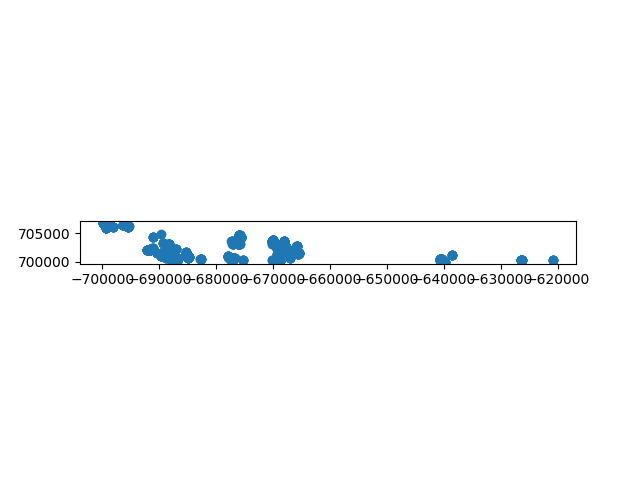

In [13]:
geodata.data.plot()

In [38]:
data.data['time'].nunique()
(data.data['time'].max()-data.data['time'].min())/60/60/24 #time span in days

3173.9490393518518

mean swath: 3878.2627 mean glaciers: -22055.398242549854


<IPython.core.display.Javascript object>


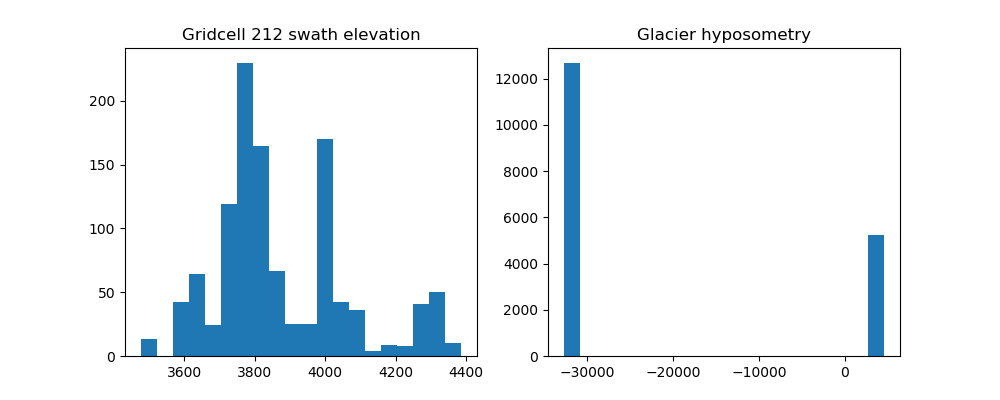

Text(0.5, 1.0, 'Glacier hyposometry')

In [50]:
%matplotlib notebook
print('mean swath: %s mean glaciers: %s' % (data.data['elev'].mean(),geoPoints.data['elev'].mean()))
fig,ax=plt.subplots(1,2, figsize=(10,4))
ax[0].hist(data.data['elev'],bins=20)
ax[0].set_title('Gridcell 212 swath elevation')
ax[1].hist(geoPoints.data['elev'],bins=20)
ax[1].set_title('Glacier hyposometry')
